## Simulation-Based Inference: Type1a Supernovae
## Data Generation
>Created: Mar. 29, 2023, for CLASHEP 2023, San Esteban, Chile, Harrison B. Prosper<br>
>Updated: Apr. 7, 2023 HBP

## Introduction

In the simplest models, a __[Type Ia supernova](https://en.wikipedia.org/wiki/Type_Ia_supernova)__ is thought to be the thermonuclear detonation of a carbon-oxygen white dwarf whose mass has reached the __[Chandrasekhar limit](https://en.wikipedia.org/wiki/Chandrasekhar_limit)__ of about 1.4 times the mass of the Sun. Beyond that mass limit, the "quantum pressure" of the electrons due to the Pauli exclusion principle is insufficient to keep the white dwarf stable. The favored model is a binary system in which a white dwarf accretes hydrogen from its red giant partner until the white dwarf reaches the point of thermonuclear instability. The fact that roughly the same mass explodes each time, namely 1.4 solar masses, which yields an immensely luminous event, makes Type 1a supernovae excellent markers for measuring cosmological distances. While there is some variation in the luminosity of these explosions, it turns out that through a simple empirical procedure it is possible to convert these explosions into standard candles. Given a standard candle, that is, a system of known luminosity and therefore known intrinsic brightness, and given the system's apparent brightness, the inverse square law can be used to infer the distance to the system. If we can determine the distance and redshift $z = (\lambda_o - \lambda_e)/ \lambda_e$ for many Type 1a supernovae, we can use these data (and others) to infer the parameters of cosmological models. The observed wavelength $\lambda_o$ is readily measured, while the emitted wavelength $\lambda_e$, that is, the wavelength of the light emitted by the supernova in its rest frame, can be inferred by identifying the known spectral lines of the excited atoms and molecules in the supernova.

## Simulations

In this notebook, we simulate many instances of distance modulus/redshift data. Each data instance comprises simulated data for 580 Type 1a supernovae generated from  the 2-parameter cosmological model described in __phantom_model.ipynb__. For every parameter point $\theta \equiv (n, H_0)$, where $n$ is a dimensionless index and $H_0$ is the Hubble constant, we simulate one instance of data taking as fixed the 580 redshifts in the [Supernova Cosmology Project Union 2.1 compilation](https://supernova.lbl.gov/Union/) and the 580 standard deviations associated with the 580 distance modulus measurements. We assume that the uncertainties in the redshifts and the standard deviations are negligible and that the only data that vary over the simulations are the distance moduli. The covariance matrix for the Union 2.1 compilation is taken to be diagonal. 

In [1]:
from tqdm import tqdm

In [2]:
%run phantom_model.ipynb

number of observations: 580
     	         z	         x +/- dx        
    0	     0.028	   35.3466 +/- 0.2239    
  100	     0.065	   37.3067 +/- 0.1628    
  200	     0.194	   39.9615 +/- 0.1264    
  300	     0.620	   43.2280 +/- 0.3903    
  400	     0.710	   43.0220 +/- 0.1843    
  500	     0.564	   42.3729 +/- 0.2920    
number of observations used: 580

type1a_union_2_1_data.pdf


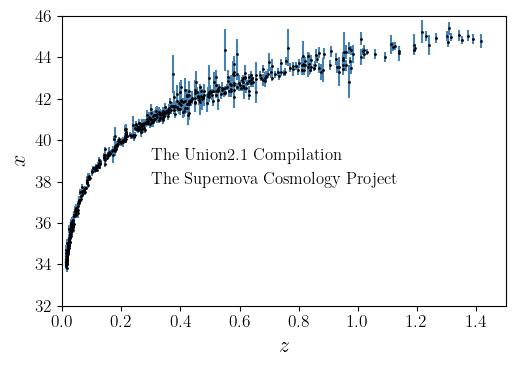

In [3]:
# place results in a bag for later use
class Bag: pass

bag = Bag()

bag.name = 'phantom'

filename = '../data/type1a_union2.1.txt'
bag.z, bag.x, bag.dx = read_data(filename)

bag.box  = False # if true place a box around parameter space

# initialize parameters
bag.guess= np.array([3.0, 70.0])
Ndata    = len(bag.z)

print(f'number of observations used: {Ndata:d}')

plot_data(bag)

### Fit using scipy optimize

In [4]:
results = op.minimize(nll, bag.guess, args=(bag,))
bag.cov = results.hess_inv
bag.res = results.x

print('\nFitted values of parameters for %s model' % bag.name)
for i in range(len(bag.res)):
    print(f'{bag.res[i]:5.2f} +/-{np.sqrt(bag.cov[i,i]):5.2f}')


Fitted values of parameters for phantom model
 2.81 +/- 0.01
70.41 +/- 0.10


### Perform fit using the *iminuit* wrapper

If you have iminuit installed, unfreeze this cell by commenting out the %%script command.

In [5]:
#%%script false --no-raise-error

# Tell Minuit that the cost function is negative log-likelihood
# rather than a chisquare so that the Hessian is scaled correctly.
#nll.errordef = im.Minuit.LEAST_SQUARES

# nice wrapper around the CERN minimization package MINUIT
import iminuit as im

nll.errordef = im.Minuit.LIKELIHOOD

bag.box = False # impose a boundary on parameter space

results = im.minimize(nll, bag.guess, args=(bag,)) 
bag.res = results.x
bag.cov = results.hess_inv

print('\nFitted values of parameters for %s model' % bag.name)
for i in range(len(bag.res)):
    print(f'{bag.res[i]:5.2f} +/-{np.sqrt(bag.cov[i,i]):5.2f}')


Fitted values of parameters for phantom model
 2.81 +/- 0.19
70.41 +/- 0.45


### Plot Results


fig_phantom_union_fit.pdf


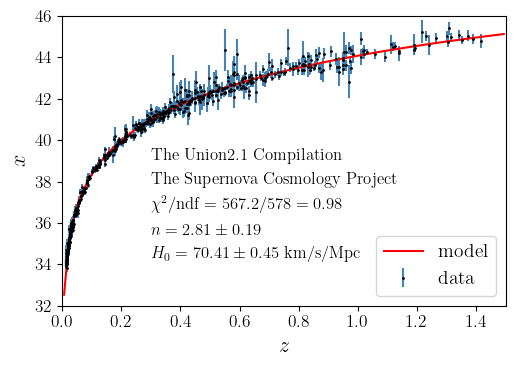

In [6]:
plot_data(bag, nll)

### Generate simulated data sets

For each point $\theta \equiv (n, H_0) \in (0.5, 6)\otimes(66, 76)$ generate a single data instance, $D$, comprising data for $N = 580$ Type 1a supernova, and compute the test statistic

\begin{align}
    \lambda(D, \theta) & = \sqrt{\frac{1}{N} \sum_{i=1}^N \left(\frac{x_i - \mu(z_i, \theta)}{\sigma_i}\right)^2},
\end{align}

where $x_i \pm \sigma_i$ is the measured distance modulus for supernova $i$, $z_i$ is its measured redshift, and $\mu(z_i, \theta)$ is the predicted distance modulus given the assumed cosmological model and a point $\theta$ in the parameter space of the model.

We sample using a uniform prior, but, in principle, any reasonable prior will do.

In [7]:
# parameter subspace
bag.nmin =  0.5
bag.nmax =  6.0
bag.hmin = 66.0
bag.hmax = 76.0

In [13]:
# sample using a uniform prior
N     = 275000
bag.n = np.random.uniform(bag.nmin, bag.nmax, N)
bag.H = np.random.uniform(bag.hmin, bag.hmax, N)
mu    = [0]*N
x     = [0]*N

# generate data sets
for i in tqdm(range(N)):

    # (1) compute predicted distance moduli for hypothesis (n, H)
    n    = bag.n[i]
    H    = bag.H[i]
    mu[i]= distance_modulus(bag.z, n, H) 
    
    # (2) simulate distance moduli for hypothesis (n, H) and compute test statistic
    x[i] = np.random.normal(loc=mu[i], scale=bag.dx)

100%|████████████████████████████████| 275000/275000 [00:17<00:00, 16172.85it/s]


In [14]:
print('\ncomputing lo test statistics and Z indicators...')

# reserve space for test statistics computed using observed data
l0 = np.zeros(N)

# reserve space for test statistics computed using simulated "observed" data
lo = np.zeros(N)

# reserve space for test statistics
l  = np.zeros(N)

# compute test statistics

# indices to randomly shuffle simulated data
ii = np.arange(0, N, 1)
np.random.shuffle(ii)

for i in tqdm(range(N)):
    
    # (1) compute test statistic using observed distance moduli
    y     = (bag.x - mu[i])/bag.dx
    l0[i] = (y**2).mean()
    
    # (2) compute test statistic using simulated "observed" distance moduli
    y     = (x[ii[i]] - mu[i])/bag.dx 
    lo[i] = (y**2).mean()

    # (3) compute test statistic using simulated distance moduli
    y     = (x[i] - mu[i])/bag.dx 
    l[i]  = (y**2).mean()

# take square-root of test statistics to reduce their dynamic ranges
l0 = np.sqrt(l0)
lo = np.sqrt(lo)
l  = np.sqrt(l)

# compute indicator variables
Z0 = (l <= l0).astype(int)
Zo = (l <= lo).astype(int)


computing lo test statistics and Z indicators...


100%|████████████████████████████████| 275000/275000 [00:03<00:00, 80978.29it/s]


In [15]:
import pandas as pd

# save to a pandas DataFrame
df = pd.DataFrame({'n':  bag.n, 
                   'H0': bag.H,
                   'l':  l, 
                   'l0': l0,
                   'lo': lo,
                   'Z0': Z0, 
                   'Zo': Zo})

os.system('rm -rf ../data/type1a_simdata.csv*')

outfile = '../data/type1a_simdata.csv.gv'
print(outfile)
df.to_csv(outfile, index=False, compression='gzip')

print('done!')

data/type1a_simdata.csv
done!
